In [5]:
import numpy as np
import os
import matplotlib.pyplot as plt
import networkx as nx
import scipy
from sklearn.cluster import KMeans
from sklearn.cluster import spectral_clustering
import helpers
import importlib

In [6]:
importlib.reload(helpers)
# Load graph and adjacency matrix
graph_file = "ca-GrQc.txt"

graph_data, header = helpers.load_graph(graph_file)
adjacency_matrix = helpers.calculate_adjacency_matrix(graph_data)

print(header)

# ca-GrQc 4158 13428 2


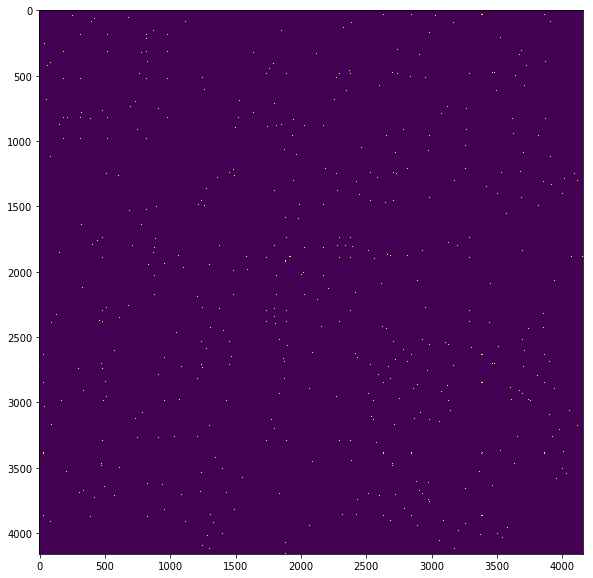

In [7]:
plt.figure(figsize=(10,10))
plt.imshow(adjacency_matrix)

In [8]:
# Initialize networkx graph for visualization and faster laplacian calculation
graph = nx.from_numpy_matrix(adjacency_matrix)

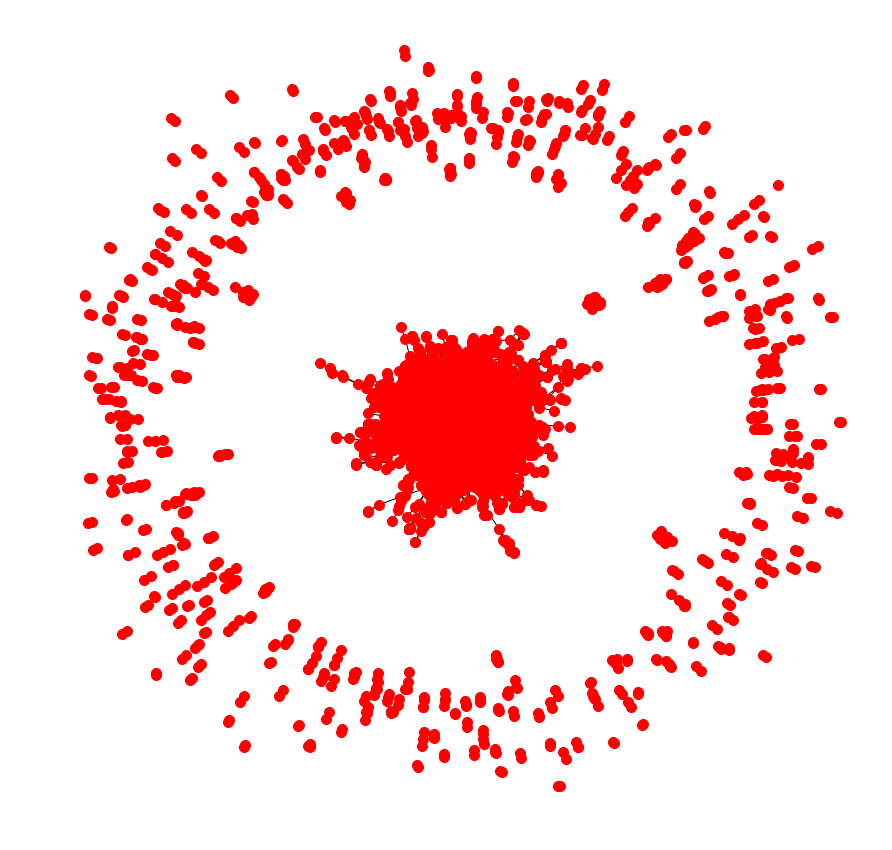

In [13]:
# Plot graph
fig, ax = plt.subplots(1,1, figsize=(15,15))
nx.draw(graph, with_labels=False, ax=ax, node_size=100) # Warning: takes a long time to run

In [10]:
A = adjacency_matrix
D = helpers.calculate_degree_mat(A)
L = helpers.calculate_normalized_laplacian(A,D)

In [11]:
L_b = nx.normalized_laplacian_matrix(graph) 

In [12]:
L_b.data

array([ 1.        , -0.28867513,  1.        , ..., -0.70710678,
       -0.70710678,  1.        ])

In [13]:
L_b.indices

array([   0, 5040,    1, ...,   44, 2256, 5241], dtype=int32)

In [14]:
k = 2

In [16]:
# Benchmark against sklearn 
labels = spectral_clustering(adjacency_matrix, n_clusters=k, eigen_solver='arpack')
print(helpers.objective_function(graph_data, labels))
print(np.unique(labels, return_counts=True))

0.22857142857142856
(array([0, 1], dtype=int32), array([4123,   35]))


In [29]:
importlib.reload(helpers)
# Do spectral cluster alg
U_norm, C_labels = helpers.spectral_cluster(graph=graph, k=k, normalized=True, random_state=0)
print(helpers.objective_function(graph_data, C_labels))
print(np.unique(C_labels, return_counts=True))

2.8
(array([0, 1], dtype=int32), array([4143,   15]))


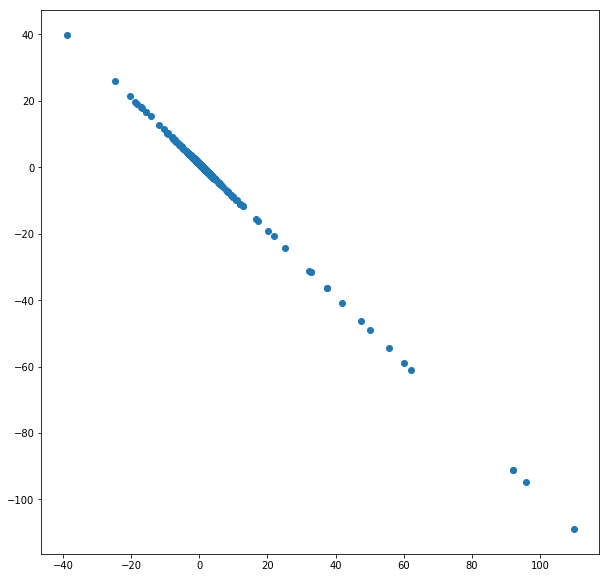

In [18]:
fig, ax = plt.subplots(1,1, figsize=(10,10))
plt.scatter(U_norm[:,0], U_norm[:,1])

In [18]:
np.unique(C_labels)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19], dtype=int32)

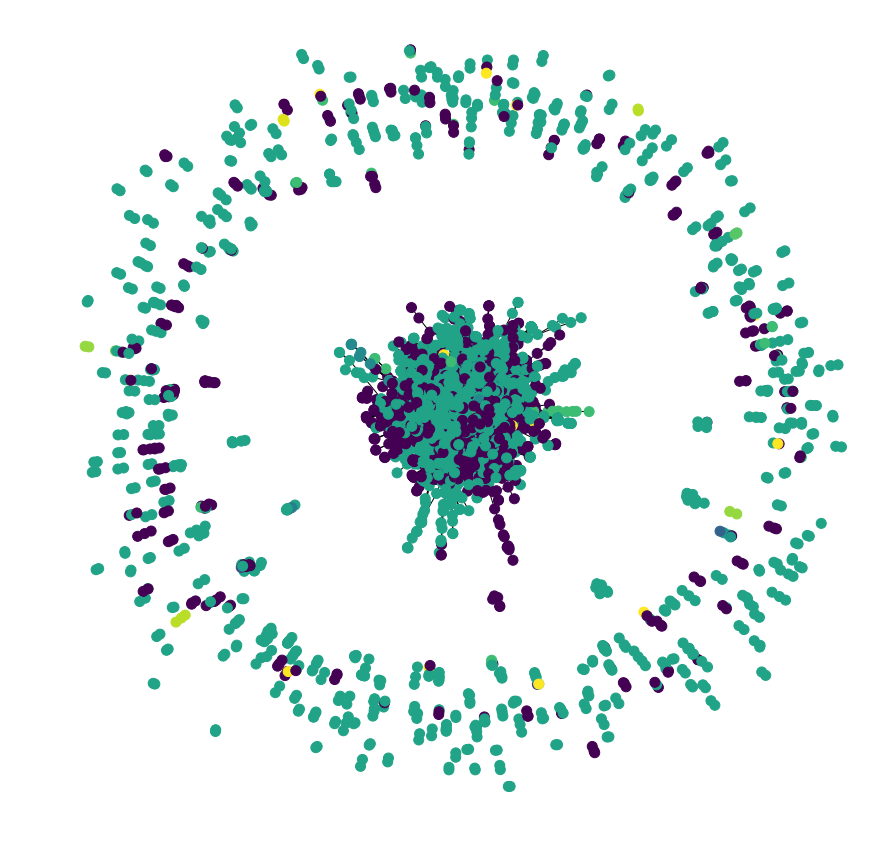

In [24]:
fig, ax = plt.subplots(1,1, figsize=(15,15))
nx.draw(graph, with_labels=False, ax=ax, node_size=100, node_color=C_labels) 

In [19]:
importlib.reload(helpers)
# Do spectral cluster alg
B_norm, B_labels = helpers.spectral_cluster(graph=graph, k=k, normalized=True, cluster_alg=helpers.BalancedKMeans, random_state=0)
print(helpers.objective_function(graph_data, B_labels))
print(np.unique(B_labels, return_counts=True))

Change less than 0.000001. Episode:  6
0.9716073147256978
(array([0, 1]), array([2078, 2080]))


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/networkx/drawing/layout.py", line 459, in fruchterman_reingold_layout
    dim, seed)
  File "<decorator-gen-786>", line 2, in _sparse_fruchterman_reingold
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/networkx/utils/decorators.py", line 405, in _random_state
    return func(*new_args, **kwargs)
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/networkx/drawing/layout.py", line 595, in _sparse_fruchterman_reingold
    distance = np.sqrt((delta**2).sum(axis=0))
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/numpy/core/_methods.py", line 36, in _sum
    return umr_sum(a, axis, dtype, out, keepdims, initial)
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Library/Frameworks/P

TypeError: must be str, not list

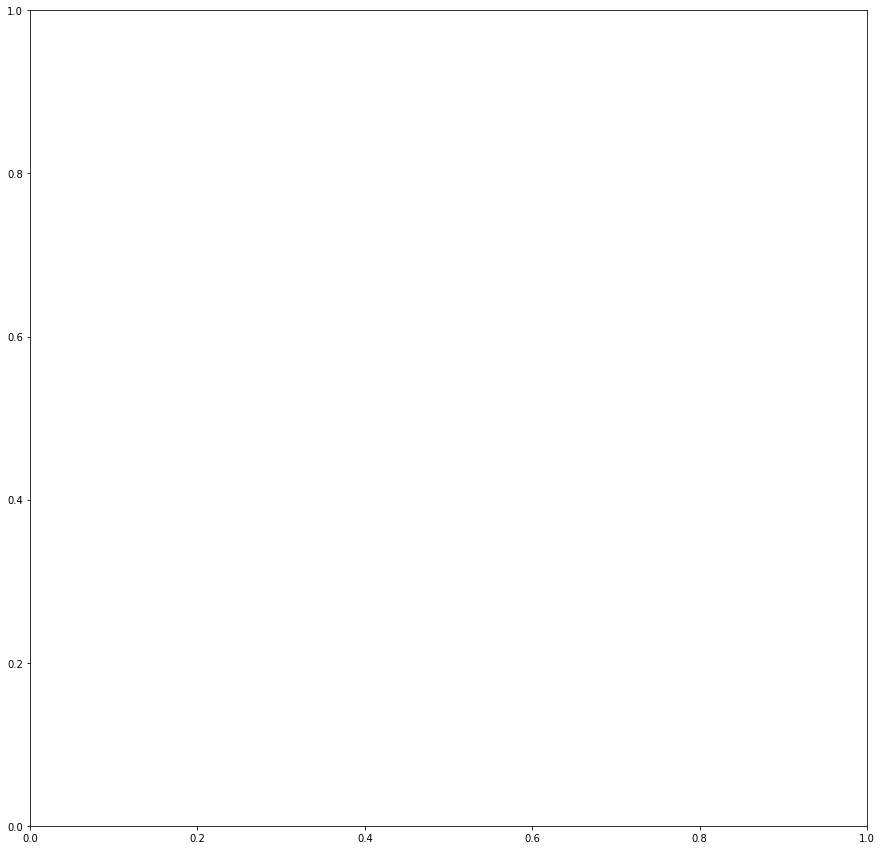

In [20]:
fig, ax = plt.subplots(1,1, figsize=(15,15))
nx.draw(graph, with_labels=False, ax=ax, node_size=100, node_color=B_labels) 